# Assumptions

#### 1. Known data before predicting Quota Premium

- Quota for current bidding exercise

- Total Bids Received for current bidding exercise

- Vehicle Population data up to previous month

- Vehicle Registration data up to previous month

- Vehicle Deregistration data up to previous month

- Transport CPI data up to previous month

#### 2. Model

- The model can only be used to predict Quota Premium of a bidding exercise where the Quota and Total Bids Received are available
- 2 separate models are trained to predict Quota Premium for Category A and Category B vehicles

# Load Data

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt

### Raw data

This is the *combined_df* used in data exploration

In [2]:
raw_data = pd.read_csv("./data/combined_df.csv")

raw_data["Announcement Date"] = pd.to_datetime(raw_data["Announcement Date"])
raw_data

,Bidding Exercise,Announcement Date,Year,Category,Quota,Quota Premium,Total Bids Received,Number of Successful Bids,Bidding Timestamp,Vehicle Population,Registration,Deregistration,Population Change,Transport CPI
0,NaN,NaT,NaN,B,NaN,NaN,NaN,NaN,47768.0,49128.0,213.0,157.0,56.0,58.3
1,NaN,NaT,NaN,A,NaN,NaN,NaN,NaN,47768.0,219348.0,1365.0,1308.0,57.0,58.3
2,NaN,NaT,NaN,B,NaN,NaN,NaN,NaN,47769.0,49128.0,213.0,157.0,56.0,58.3
3,NaN,NaT,NaN,A,NaN,NaN,NaN,NaN,47769.0,219348.0,1365.0,1308.0,57.0,58.3
4,NaN,NaT,NaN,A,NaN,NaN,NaN,NaN,47770.0,219746.0,1442.0,1044.0,398.0,58.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1523,January 2022 Second Open Bidding Exercise,2022-01-19,2022.0,A,531.0,57898.0,711.0,526.0,48529.0,321432.0,1315.0,1383.0,-68.0,115.8
1524,February 2022 First Open Bidding Exercise,2022-02-09,2022.0,A,542.0,60761.0,819.0,542.0,48530.0,NaN,NaN,NaN,NaN,NaN
1525,February 2022 First Open Bidding Exercise,2022-02-09,2022.0,B,550.0,86102.0,865.0,549.0,48530.0,NaN,NaN,NaN,NaN,NaN
1526,February 2022 Second Open Bidding Exercise,2022-02-23,2022.0,A,536.0,63000.0,876.0,524.0,48531.0,NaN,NaN,NaN,NaN,NaN


### Get time shifted features from raw data

In the experiment, I have tried and used different features combinations with time shifting periods on Cat A and Cat B, before setting *columns_shifts_A* and *columns_shifts_B* to the one shown below.

In [3]:
def get_time_shifted_data_for_category(df: pd.DataFrame,  columns_shifts, category):
    df = df.copy()
    target_cols = list()

    for col in columns_shifts:
        for num_shift in columns_shifts[col]:
            num_shift = int(num_shift)
            if num_shift == 0:
                target_cols.append(col)
                continue
            new_col = "{} Lagged {}".format(col, num_shift)
            temp_df = pd.DataFrame({
                "Bidding Timestamp": df["Bidding Timestamp"] + num_shift,
                "Category": df["Category"],
                new_col: df[col]
            })
            df = pd.merge(df, temp_df, how="left", on=["Bidding Timestamp", "Category"])
            target_cols.append(new_col)
    
    data = df[target_cols]
    data = data.dropna()
    data = data.sort_values(by=["Announcement Date", "Category"])
    data = data[data["Category"]==category].reset_index(drop=True)
    return data

#### Data for Cat A

In [4]:
columns_shifts_A = {
    "Category": [0], # current bidding exercise
    "Announcement Date": [0], # current bidding exercise
    "Quota Premium": [0, 1], # current bidding exercise and 1 bidding exercise back
    "Quota": [24 * 2], # 2 years back
    "Total Bids Received": [24 * 2], # 2 years back
    "Vehicle Population": [2], # 1 month back
    "Registration": [2], # 1 month back
    "Deregistration": [2], # 1 month back
    "Population Change": [2], # 1 month back
    "Transport CPI": [2] # 1 month back
}

data_A = get_time_shifted_data_for_category(raw_data, columns_shifts_A, "A")
data_A

,Category,Announcement Date,Quota Premium,Quota Premium Lagged 1,Quota Lagged 48,Total Bids Received Lagged 48,Vehicle Population Lagged 2,Registration Lagged 2,Deregistration Lagged 2,Population Change Lagged 2,Transport CPI Lagged 2
0,A,2004-04-01,26689.0,24940.0,1110.0,2484.0,258532.0,5271.0,6340.0,-1069.0,75.7
1,A,2004-04-15,27564.0,26689.0,1149.0,1890.0,258532.0,5271.0,6340.0,-1069.0,75.7
2,A,2004-05-01,27507.0,27564.0,1128.0,1705.0,257931.0,4391.0,4992.0,-601.0,75.8
3,A,2004-05-15,27501.0,27507.0,1111.0,1320.0,257931.0,4391.0,4992.0,-601.0,75.8
4,A,2004-06-01,28798.0,27501.0,1111.0,1382.0,257392.0,4349.0,4888.0,-539.0,76.6
...,...,...,...,...,...,...,...,...,...,...,...
418,A,2021-12-22,58801.0,57010.0,1029.0,1256.0,321406.0,1352.0,1198.0,154.0,114.2
419,A,2022-01-05,57599.0,58801.0,1035.0,1450.0,321500.0,1191.0,1097.0,94.0,115.7
420,A,2022-01-19,57898.0,57599.0,1034.0,1390.0,321500.0,1191.0,1097.0,94.0,115.7
421,A,2022-02-09,60761.0,57898.0,982.0,1204.0,321432.0,1315.0,1383.0,-68.0,115.8


#### Data for Cat B

In [5]:
columns_shifts_B = {
    "Category": [0], # current bidding exercise
    "Announcement Date": [0], # current bidding exercise
    "Quota Premium": [0, 1], # current bidding exercise and 1 bidding exercise back
    "Quota": [24 * 2], # 2 years back
    "Total Bids Received": [24 * 2], # 2 years back
    "Population Change": [2], # 1 month back
    "Transport CPI": [2] # 1 month back
}

data_B = get_time_shifted_data_for_category(raw_data, columns_shifts_B, "B")
data_B

,Category,Announcement Date,Quota Premium,Quota Premium Lagged 1,Quota Lagged 48,Total Bids Received Lagged 48,Population Change Lagged 2,Transport CPI Lagged 2
0,B,2004-04-01,28001.0,25058.0,558.0,1119.0,999.0,75.7
1,B,2004-04-15,28022.0,28001.0,553.0,1104.0,999.0,75.7
2,B,2004-05-01,26700.0,28022.0,560.0,1043.0,958.0,75.8
3,B,2004-05-15,27990.0,26700.0,552.0,894.0,958.0,75.8
4,B,2004-06-01,30300.0,27990.0,595.0,885.0,937.0,76.6
...,...,...,...,...,...,...,...,...
418,B,2021-12-22,80989.0,80401.0,1015.0,1251.0,429.0,114.2
419,B,2022-01-05,77700.0,80989.0,1022.0,1229.0,529.0,115.7
420,B,2022-01-19,82001.0,77700.0,1012.0,1157.0,529.0,115.7
421,B,2022-02-09,86102.0,82001.0,984.0,1173.0,446.0,115.8


# Train test split for Cat A and Cat B

The raw data is splited at the ratio of 5:1 for train and test, where the most recent 1/6 of the data is used as the test data

In [6]:
def train_test_split(data, split_ratio):
    X = data.drop(columns=["Quota Premium", "Announcement Date", "Category"])
    y = data["Quota Premium"]

    split_index = int(len(X) * split_ratio)

    X_train, X_test = X[:split_index], X[split_index:]
    y_train, y_test = y[:split_index], y[split_index:]

    return X_train, X_test, y_train, y_test, split_index

split_ratio = 5/6

#### Cat A

Total train data for Cat A: 352
Total test data for Cat A: 71


,Quota Premium Lagged 1,Quota Lagged 48,Total Bids Received Lagged 48,Vehicle Population Lagged 2,Registration Lagged 2,Deregistration Lagged 2,Population Change Lagged 2,Transport CPI Lagged 2
0,24940.0,1110.0,2484.0,258532.0,5271.0,6340.0,-1069.0,75.7
1,26689.0,1149.0,1890.0,258532.0,5271.0,6340.0,-1069.0,75.7
2,27564.0,1128.0,1705.0,257931.0,4391.0,4992.0,-601.0,75.8
3,27507.0,1111.0,1320.0,257931.0,4391.0,4992.0,-601.0,75.8
4,27501.0,1111.0,1382.0,257392.0,4349.0,4888.0,-539.0,76.6
...,...,...,...,...,...,...,...,...
347,30209.0,2008.0,2610.0,317500.0,2721.0,4001.0,-1280.0,99.2
348,28000.0,2064.0,2938.0,316501.0,2887.0,3886.0,-999.0,99.0
349,28457.0,2023.0,2584.0,316501.0,2887.0,3886.0,-999.0,99.0
350,25556.0,1929.0,2800.0,315863.0,3018.0,3656.0,-638.0,99.1


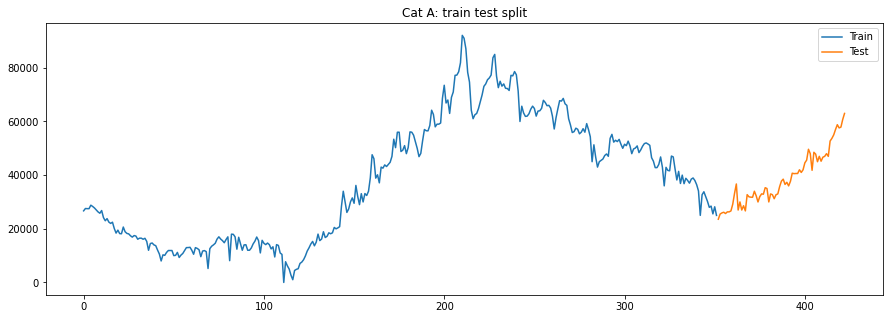

In [7]:
X_A_train, X_A_test, y_A_train, y_A_test, split_index_A = train_test_split(data_A, split_ratio)

print("Total train data for Cat A: {}".format(len(X_A_train)))
print("Total test data for Cat A: {}".format(len(X_A_test)))

plt.figure(figsize=(15,5))
plt.title('Cat A: train test split', size=12)
plt.plot(y_A_train, label='Train')
plt.plot(y_A_test, label='Test')
plt.legend()

X_A_train

#### Cat B

Total train data for Cat B: 352
Total test data for Cat B: 71


,Quota Premium Lagged 1,Quota Lagged 48,Total Bids Received Lagged 48,Population Change Lagged 2,Transport CPI Lagged 2
0,25058.0,558.0,1119.0,999.0,75.7
1,28001.0,553.0,1104.0,999.0,75.7
2,28022.0,560.0,1043.0,958.0,75.8
3,26700.0,552.0,894.0,958.0,75.8
4,27990.0,595.0,885.0,937.0,76.6
...,...,...,...,...,...
347,32001.0,1338.0,2017.0,459.0,99.2
348,31307.0,1350.0,1785.0,724.0,99.0
349,31301.0,1340.0,1768.0,724.0,99.0
350,31302.0,1347.0,2012.0,1085.0,99.1


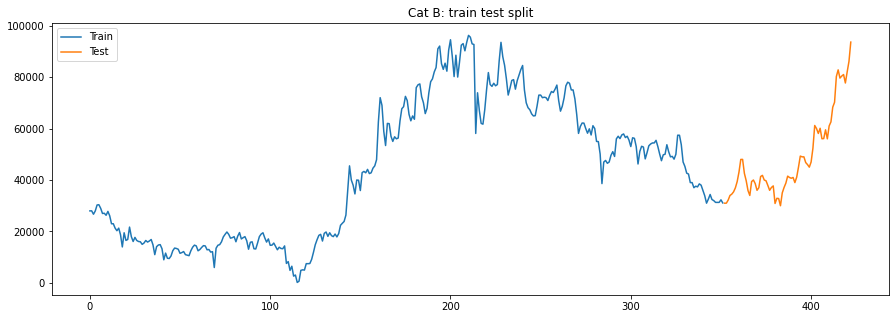

In [8]:
X_B_train, X_B_test, y_B_train, y_B_test, split_index_B = train_test_split(data_B, split_ratio)

print("Total train data for Cat B: {}".format(len(X_B_train)))
print("Total test data for Cat B: {}".format(len(X_B_test)))

plt.figure(figsize=(15,5))
plt.title('Cat B: train test split', size=12)
plt.plot(y_B_train, label='Train')
plt.plot(y_B_test, label='Test')
plt.legend()

X_B_train

# Train model

2 regression models were experimented:
- Multi Layer Perceptron Regressor
    - consists of several fully connected hidden layers, where each layer is made up of different number of neurons
    - learns a non linear function that maps the input to the output
- Gradient Boosting Regressor
    - builds an additive model with decision trees are used as weak learners
    - calculates difference between between prediction and true value, which is called the residuals
    - training proceeds iteratively, adding new trees that predict the residuals of prior trees that are then combined with previous trees to make the final prediction
    - uses gradient descent algorithm to minimize the loss when adding new models

Hyperparameter tuning was done using Randomized Search for both models.

When performing cross validation during hyperparameter tuning, walk forward validation is used.
- train data is split into 5 windows 
- at the start, the first window is used to train and second window is used to validate the model, and the score is recorded
- subsequently, train window is then expanded to second window, and the third window is used to validate
- this is called expanding window validation, where at each fold of validation, the training data covers larger history 

After that, the best parameters found from hyperparameter tuning are used to fit the final model, which will be evaluated on the test data

In [9]:
import os
import random
import numpy as np

from collections import defaultdict
from scipy.stats import randint

from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score

In [10]:
def reset_seed(seed=0):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)

In [11]:
def train_model(X, y, model_name):
    distributions = {
        "MLP": {
            "hidden_layer_sizes": [
                (2**i, 2**j, 2**k) 
                for i in range(5, 7)
                for j in range(3, 6)
                for k in range(1, 4)
            ],
            "alpha": [1e-4, 1e-3, 1e-2],
            "learning_rate_init": [0.0025, 0.0005, 0.001, 0.002, 0.004]
        },
        "GB": {
            "n_estimators": [100, 200, 500, 1000],
            "learning_rate": [0.001, 0.002, 0.004, 0.008, 0.01],
            "max_depth": randint(2, 6),
            "min_samples_split": [15, 20, 25, 30, 35],
            "min_samples_leaf": [5, 10, 15, 20],
            "alpha": [1e-4, 1e-3, 1e-2],
        }
    }

    models = {
        "MLP": (MLPRegressor(random_state=0, max_iter=500), distributions["MLP"]),
        "GB": (GradientBoostingRegressor(random_state=0), distributions["GB"])
    }

    reset_seed()

    tss = TimeSeriesSplit(n_splits=4)
    model, param_distributions = models[model_name]

    print("Performing randomized search for {}...".format(model_name))
    randomized_search = RandomizedSearchCV(
        model, 
        param_distributions=param_distributions, 
        n_iter=100,
        n_jobs=4,
        scoring="neg_root_mean_squared_error",
        cv=tss,
        refit=True,
        verbose=1,
        random_state=0
    )
    randomized_search.fit(X, y)
    best_model = randomized_search.best_estimator_
    print("Done! Best score: {} \nBest parameters:\n{}\n".format(randomized_search.best_score_, randomized_search.best_params_))

    return best_model

def run_train(X_A_train, X_B_train, model_names):
    best_models = defaultdict(list)

    for model in model_names:
        best_models[model].append(
            train_model(X_A_train, y_A_train, model)
        )
        best_models[model].append(
            train_model(X_B_train, y_B_train, model)
        )
    
    return best_models

In [12]:
# MLP: Multi Layer Perceptron Regressor
# GB: Gradient Boosting Regressor
model_names = ["MLP", "GB"]

all_models = run_train(X_A_train, X_B_train, model_names)
all_models

Performing randomized search for MLP...
Fitting 4 folds for each of 100 candidates, totalling 400 fits


/Users/jyuteo/miniconda3/envs/carro/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/jyuteo/miniconda3/envs/carro/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/jyuteo/miniconda3/envs/carro/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/jyuteo/miniconda3/envs/carro/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  war

Done! Best score: -3490.1612063921607 
Best parameters:
{'learning_rate_init': 0.002, 'hidden_layer_sizes': (32, 8, 4), 'alpha': 0.0001}

Performing randomized search for MLP...
Fitting 4 folds for each of 100 candidates, totalling 400 fits


/Users/jyuteo/miniconda3/envs/carro/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/jyuteo/miniconda3/envs/carro/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/jyuteo/miniconda3/envs/carro/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/jyuteo/miniconda3/envs/carro/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  war

Done! Best score: -4036.54642436387 
Best parameters:
{'learning_rate_init': 0.0005, 'hidden_layer_sizes': (32, 32, 4), 'alpha': 0.001}

Performing randomized search for GB...
Fitting 4 folds for each of 100 candidates, totalling 400 fits
Done! Best score: -11248.183198705136 
Best parameters:
{'alpha': 0.01, 'learning_rate': 0.008, 'max_depth': 4, 'min_samples_leaf': 5, 'min_samples_split': 30, 'n_estimators': 500}

Performing randomized search for GB...
Fitting 4 folds for each of 100 candidates, totalling 400 fits
Done! Best score: -16306.205138712749 
Best parameters:
{'alpha': 0.001, 'learning_rate': 0.004, 'max_depth': 3, 'min_samples_leaf': 15, 'min_samples_split': 30, 'n_estimators': 500}



defaultdict(list,
            {'MLP': [MLPRegressor(hidden_layer_sizes=(32, 8, 4), learning_rate_init=0.002,
                           max_iter=500, random_state=0),
              MLPRegressor(alpha=0.001, hidden_layer_sizes=(32, 32, 4),
                           learning_rate_init=0.0005, max_iter=500, random_state=0)],
             'GB': [GradientBoostingRegressor(alpha=0.01, learning_rate=0.008, max_depth=4,
                                        min_samples_leaf=5, min_samples_split=30,
                                        n_estimators=500, random_state=0),
              GradientBoostingRegressor(alpha=0.001, learning_rate=0.004, min_samples_leaf=15,
                                        min_samples_split=30, n_estimators=500,
                                        random_state=0)]})

# Evaluation

On top of comparing the model performance between MLP and GB Regressor, I also compared them with a baseline prediction.

The baseline that I used is naive forecast, which means using the value at previous time step (t-1) as the prediction for current time step (t).

Metrics used:
- Root mean squared error
- Mean absolute percentage error
- R2

More explanation for metrics is in *3.open_ended_questions.md*

### Use Naive forecast as baseline prediction

Using the value at previous time step (t-1) as the prediction for the current time step (t)

Predicted Quota Premium(t) = Actual Quota Premium(t-1)

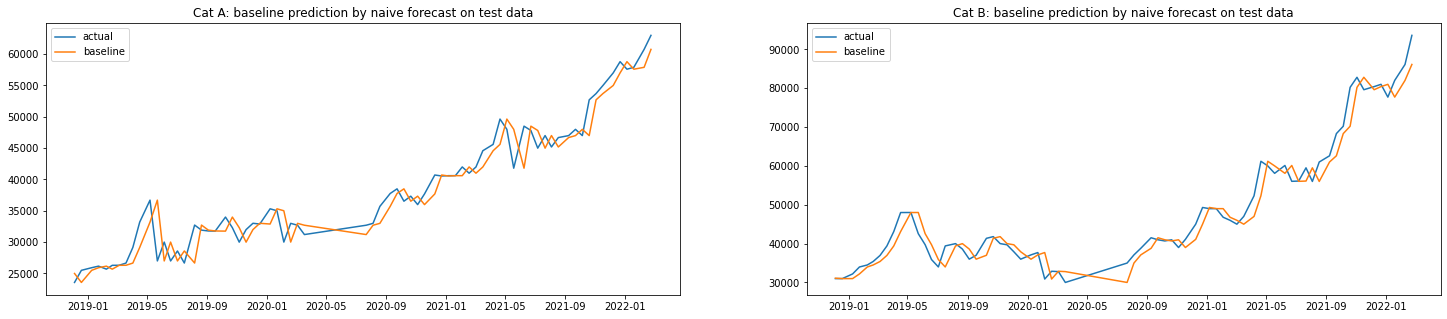

In [13]:
y_A_baseline = list(data_A["Quota Premium"][split_index_A-1:-1])
y_B_baseline = list(data_B["Quota Premium"][split_index_B-1:-1])

f, ax = plt.subplots(1, 2, figsize=(25, 5))

ax[0].plot(data_A["Announcement Date"][split_index_A:], y_A_test, label="actual")
ax[0].plot(data_A["Announcement Date"][split_index_A:], y_A_baseline, label="baseline")
ax[0].set_title('Cat A: baseline prediction by naive forecast on test data', size=12)
ax[0].legend()

ax[1].plot(data_B["Announcement Date"][split_index_B:], y_B_test, label="actual")
ax[1].plot(data_B["Announcement Date"][split_index_B:], y_B_baseline, label="baseline")
ax[1].set_title('Cat B: baseline prediction by naive forecast on test data', size=12)
ax[1].legend()

In [14]:
y_A_baseline = list(data_A["Quota Premium"][split_index_A-1:-1])
y_B_baseline = list(data_B["Quota Premium"][split_index_B-1:-1])

baseline_results = {
    "A": {
        "root mean squared error" : mean_squared_error(
            y_A_test, y_A_baseline, squared=False
        ),
        "mean absolute percentage error": mean_absolute_percentage_error(y_A_test, y_A_baseline),
        "r2 score": r2_score(y_A_test, y_A_baseline)
    },
    "B": {
        "root mean squared error" : mean_squared_error(
            y_B_test, y_B_baseline, squared=False
        ),
        "mean absolute percentage error": mean_absolute_percentage_error(y_B_test, y_B_baseline),
        "r2 score": r2_score(y_B_test, y_B_baseline)
    },
}

print("Baseline: naive forecast")
pd.DataFrame(baseline_results)

Baseline: naive forecast


,A,B
root mean squared error,2606.323410,3292.286467
mean absolute percentage error,0.051964,0.052030
r2 score,0.931103,0.957541


The performance of the naive forecast is good, with low mean absolute percentage error (~5%) and high r2 score (close to 1)

When evaluating our model, we will see whether the trained models can achieve better metrics results compared to the baseline predictions

In [15]:
def evaluate(A_eval_data: dict, B_eval_data: dict, baseline_results: dict, models: dict):
    results = defaultdict()
    predictions_dict = defaultdict()

    results["baseline"] = baseline_results

    predictions_dict["baseline"] = {
        "A": A_eval_data["y_baseline"],
        "B": B_eval_data["y_baseline"]
    }

    for model in models:
        for i, data in enumerate([A_eval_data, B_eval_data]) :
            y_predict = models[model][i].predict(data["X_test"])
            key_name = "A" if i == 0 else "B"

            if model not in results:
                results[model] = dict()
            results[model][key_name] = {
                "root mean squared error" : mean_squared_error(data["y_test"], y_predict, squared=False),
                "mean absolute percentage error": mean_absolute_percentage_error(data["y_test"], y_predict),
                "r2 score": r2_score(data["y_test"], y_predict)
            }

            if model not in predictions_dict:
                predictions_dict[model] = dict()
            predictions_dict[model][key_name] = y_predict

    results_df = pd.concat(
        {k: pd.DataFrame.from_dict(v, 'index') for k, v in results.items()}, 
        axis=0
    )

    return predictions_dict, results_df.T

### Results

In [16]:
A_eval_data = {
    "X_train": X_A_train,
    "y_train": y_A_train,
    "X_test": X_A_test,
    "y_test": y_A_test,
    "y_baseline": y_A_baseline
}

B_eval_data = {
    "X_train": X_B_train,
    "y_train": y_B_train,
    "X_test": X_B_test,
    "y_test": y_B_test,
    "y_baseline": y_B_baseline
}

predictions_dict, results_df = evaluate(A_eval_data, B_eval_data, baseline_results, all_models)

In [17]:
results_df

baseline                       MLP  \
                                          A            B            A   
root mean squared error         2606.323410  3292.286467  2497.298442   
mean absolute percentage error     0.051964     0.052030     0.050235   
r2 score                           0.931103     0.957541     0.936747   

                                                      GB               
                                          B            A            B  
root mean squared error         3069.765970  3079.162061  4337.420480  
mean absolute percentage error     0.048770     0.065492     0.067092  
r2 score                           0.963087     0.903837     0.926305

The results for MLP and GB shown above is the best performing model after hyperparamenter tuning and trying different combinations of time shifting the features as train data.

If we purely look at the scores for MLP and GB, both models are fairly good since they have low mean absolute percentage error (~5%) and high r2 score (close to 1).

However, the baseline prediction performs very good also. Therefore, it is hard to surpass the scores of baseline.

For Gradient Boosting, it could be said that it is slightly worse than the baseline, for having higher root mean squared error, higher mean absolute percentage error and lower r2. 

For MLP, the performance is slightly better than the baseline, for having lower root mean squared error, lower mean absolute percentage error and higher r2.


### Visualization

In [18]:
def visualize_prediction(date_indexes, predictions_dict, A_eval_data, A_split_index, B_eval_data, B_split_index):
    f, ax = plt.subplots(3, 2, figsize=(22, 15))
    f.tight_layout(h_pad=5)

    A = {
        "date": date_indexes,
        "y_train": list(A_eval_data["y_train"]) + [np.nan]*(len(A_eval_data["y_test"])),
        "actual": [np.nan]*A_split_index + list(A_eval_data["y_test"]),
        "baseline": [np.nan]*A_split_index + list(A_eval_data["y_baseline"]),
        **{
            model: [np.nan]*A_split_index + list(predictions["A"]) for model, predictions in predictions_dict.items()
        }
    }

    B = {
        "date": date_indexes,
        "y_train": list(B_eval_data["y_train"]) + [np.nan]*(len(B_eval_data["y_test"])),
        "actual": [np.nan]*B_split_index + list(B_eval_data["y_test"]),
        "baseline": [np.nan]*B_split_index + list(B_eval_data["y_baseline"]),
        **{
            model: [np.nan]*B_split_index + list(predictions["B"]) for model, predictions in predictions_dict.items()
        }
    }

    A_df = pd.DataFrame(A)
    B_df = pd.DataFrame(B)

    ax[0,0].plot(A_df["date"], A_df["y_train"], label="train")
    ax[0,0].plot(A_df["date"], A_df["actual"], color="tab:blue", linestyle="dashed", label="actual")
    ax[0,0].plot(A_df["date"], A_df["baseline"], label="baseline")
    ax[0,0].set_title("Cat A: Overview of train data and baseline prediction")
    ax[0,0].legend()

    ax[0,1].plot(B_df["date"], B_df["y_train"], label="train")
    ax[0,1].plot(B_df["date"], B_df["actual"], color="tab:blue", linestyle="dashed", alpha=0.5, label="actual")
    ax[0,1].plot(B_df["date"], B_df["baseline"], label="baseline")
    ax[0,1].set_title("Cat B: Overview of train data and baseline prediction")
    ax[0,1].legend()

    ax[1,0].plot(A_df["date"], A_df["actual"], linestyle="dashed", label="actual")
    ax[1,0].plot(A_df["date"], A_df["baseline"], linestyle="dashed", label="baseline")
    ax[1,0].plot(A_df["date"], A_df["MLP"], label="MLP")
    ax[1,0].set_title("Cat A: MLP Regressor prediction on Test data")
    ax[1,0].legend()

    ax[1,1].plot(B_df["date"], B_df["actual"], linestyle="dashed", label="actual")
    ax[1,1].plot(B_df["date"], B_df["baseline"], linestyle="dashed", label="baseline")
    ax[1,1].plot(B_df["date"], B_df["MLP"], label="MLP")
    ax[1,1].set_title("Cat B: MLP Regressor prediction on Test data")
    ax[1,1].legend()

    ax[2,0].plot(A_df["date"], A_df["actual"], linestyle="dashed", label="actual")
    ax[2,0].plot(A_df["date"], A_df["baseline"], linestyle="dashed", label="baseline")
    ax[2,0].plot(A_df["date"], A_df["GB"], color="tab:pink", label="GB")
    ax[2,0].set_title("Cat A: Gradient Boosting Regressor prediction on Test data")
    ax[2,0].legend()

    ax[2,1].plot(B_df["date"], B_df["actual"], linestyle="dashed", label="actual")
    ax[2,1].plot(B_df["date"], B_df["baseline"], linestyle="dashed", label="baseline")
    ax[2,1].plot(B_df["date"], B_df["GB"], color="tab:pink", label="GB")
    ax[2,1].set_title("Cat B: Gradient Boosting Regressor prediction on Test data")
    ax[2,1].legend()


    return A_df

    

Cat A

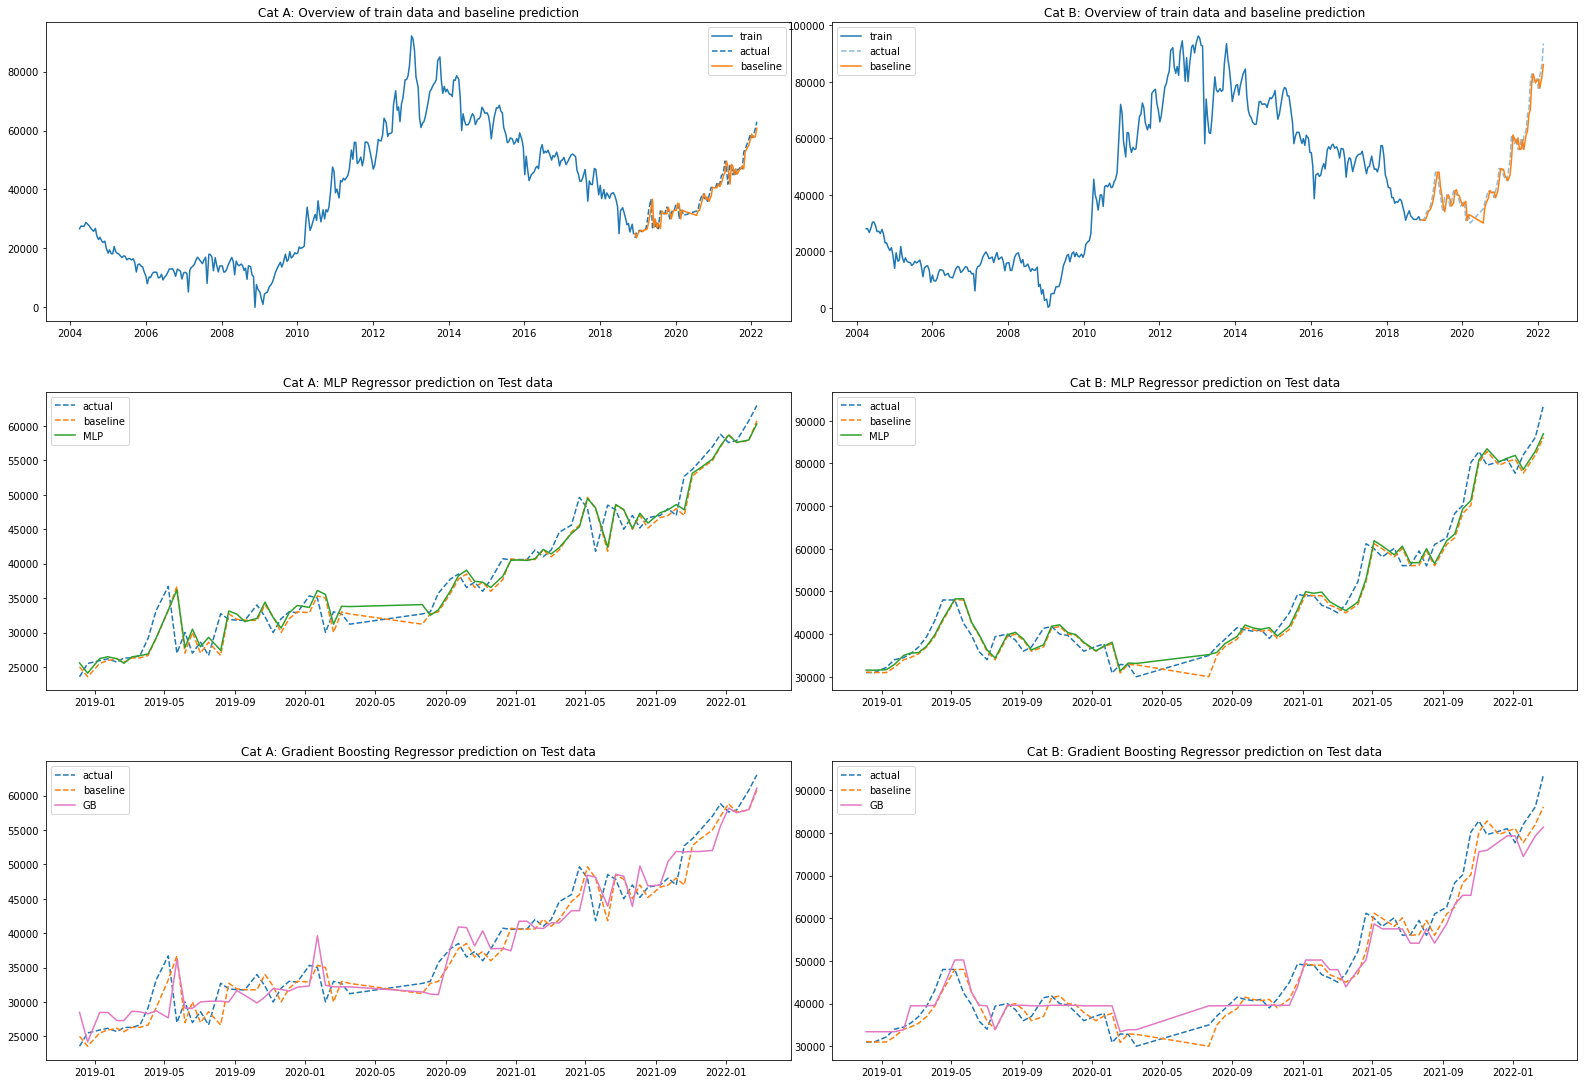

In [19]:
visualize_prediction(data_A["Announcement Date"], predictions_dict, A_eval_data, split_index_A, B_eval_data, split_index_B)
pass

From the visualization above, we can see that MLP indeed performed better than GB for both Cat A and Cat B.

However, in the case for MLP, given its high metric scores, there is around 1-step time lag between the prediction and the actual data.

# Conclusion

### Remarks on training data preparation

When doing data exploration, I tried to adjust the time shifts of the features based on the visualization and the increase in correlation value.

However, during model training, the degree of time shifting that I assumed previously didnt yield the best performing model like the ones achieved currently. Besides, I also found that using the same features and time shifting does not have the same effect on both Cat A and Cat B models. 

So, what I did when preparing features for training data for Cat A and Cat B was:
- Try different sets features with different number of time shiftings, then I observe the evaluation metrics, and compare them with the baseline model
- Use different set of features and time shifting data to train model for Cat A and Cat B

### Remarks on model performance

Besides, the baseline prediction is too good, so it seems like our models didnt have much advantage compared to the baseline.

The MLP model only performed slightly better than the baseline even though its mean absolute percentage difference is only 5%.

The good metric values by naive forecast imply that the next Quota Premium is usually close to its previous value. 

So, another possible solution for this problem is that, instead of predicting the value of the next Quota Premium, we can try to train a model that predicts the change of the Quota Premium relative to its previous month value.